In [39]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_test_transform, CUB_train_transform
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

# Standard model performance

# images: 11780
filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/174.Palm_Warbler/Palm_Warbler_0046_169837.jpg
image id: 10206
class id: 174
bird name: 174.Palm_Warbler
is_test: 1
image size: (456, 500, 3)


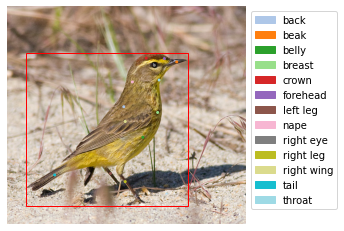

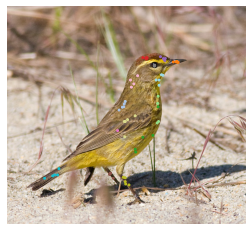

--------------- represented in dataset
image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


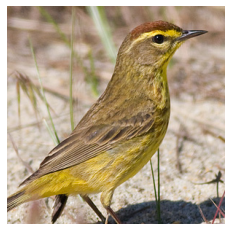

In [40]:
cub = CUB()
print('# images:', len(cub)) # should be 11788 - 8 (-8 b/c 8 gray scale images)

train_indices = [i for i in range(len(cub)) if not is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
test_indices = [i for i in range(len(cub)) if is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
cub_train = CUB_train_transform(Subset(cub, train_indices))
cub_test = CUB_test_transform(Subset(cub, test_indices))

def show_cub_data(dataset, idx):
    filename = dataset[idx]['filename']
    describe_bird(filename)

    print('--------------- represented in dataset')
    im, y = dataset[idx]['x'].permute(1,2,0), dataset[idx]['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()
    
show_cub_data(cub_test, 30)

In [3]:
# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(SubColumn(cub_train, ['x', 'y']), batch_size=32, shuffle=True, num_workers=8)
loader_xy_te = DataLoader(SubColumn(cub_test, ['x', 'y']), batch_size=32, shuffle=False, num_workers=8)

Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0
train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 0.7%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 3.764e+00


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 1.699e+00


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 1.000e+00


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 6.238e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 4.229e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 3.380e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 1.691e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 1.048e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 7.291e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   9: loss 4.827e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  10: loss 3.294e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  11: loss 2.783e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  12: loss 1.765e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  13: loss 2.506e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  14: loss 2.115e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  15: loss 3.590e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  16: loss 3.792e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  17: loss 1.823e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  18: loss 2.912e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  19: loss 1.953e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  20: loss 6.715e-03


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  21: loss 4.831e-03


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  22: loss 3.744e-03


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  23: loss 4.881e-03


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  24: loss 1.022e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  25: loss 8.924e-03


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  26: loss 4.252e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  27: loss 1.404e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch  28: loss 7.592e-03


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch  29: loss 8.823e-03


test eval: 100%|██████████| 181/181 [00:17<00:00, 10.56it/s]


task acc after training: 76.4%


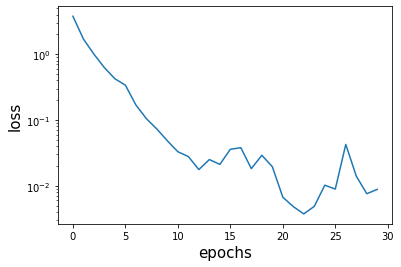

In [4]:
def standard_model(loader_xy, loader_xy_te, n_epochs=10, report_every=1, plot=True, device='cuda'):
    # regular model
    net = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
    net.fc = nn.Linear(2048, 200) # 200 bird classes
    net.to(device)
    print('task acc before training: {:.1f}%'.format(test(net, loader_xy, acc_criterion, device=device) * 100))
    
    # train
    opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # optim.Adam(net.parameters()) # adam is slower in this case
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, device=device)
    if plot: plot_log(log)
    print('task acc after training: {:.1f}%'.format(test(net, loader_xy_te, acc_criterion, device=device) * 100))        
    return net

standard_net = standard_model(loader_xy, loader_xy_te, n_epochs=30, report_every=1)


image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


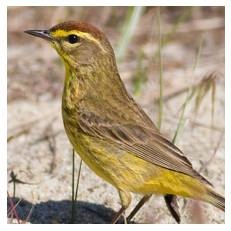

image size: torch.Size([200, 200, 3])
0-indexed class id (describe bird is 1-indexed): 173


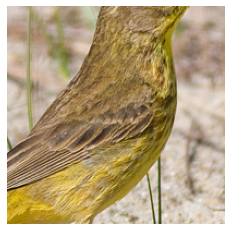

image size: torch.Size([299, 299, 1])
0-indexed class id (describe bird is 1-indexed): 173


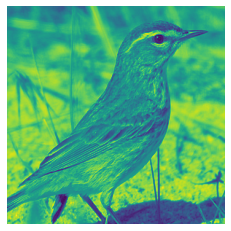

image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


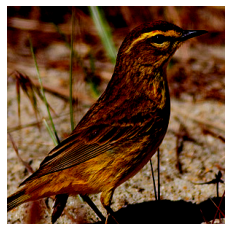

image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


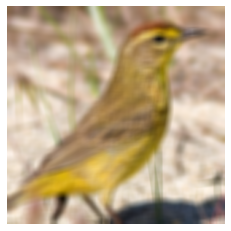

image size: torch.Size([200, 200, 3])
0-indexed class id (describe bird is 1-indexed): 173


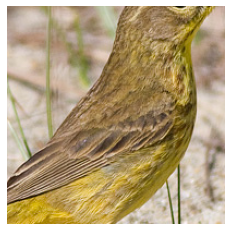

In [38]:
from torchvision.transforms import GaussianBlur, CenterCrop, ColorJitter, Grayscale, RandomCrop, RandomHorizontalFlip

def show_transform(dataset, idx, transform=lambda x: x):
    im, y = dataset[idx]['x'], dataset[idx]['y'] 
    im = transform(im)
    im = im.permute(1,2,0)
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()


show_transform(cub_test, 30, transform=lambda x: RandomHorizontalFlip(1)(x))
show_transform(cub_test, 30, transform=lambda x: RandomCrop(200)(x))
show_transform(cub_test, 30, transform=lambda x: Grayscale()(x))
show_transform(cub_test, 30, transform=lambda x: ColorJitter(brightness=32/255, saturation=(0.5, 1.5))(x))
show_transform(cub_test, 30, transform=lambda x: GaussianBlur(11, (10,20))(x))
show_transform(cub_test, 30, transform=lambda x: CenterCrop(200)(x))
